In [1]:
from joblib import dump, load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

import pickle

from pprint import pprint

In [2]:
import os
files = os.listdir('./distanceResults')
pprint(sorted(files))

['.ipynb_checkpoints',
 'ANMM.pkl',
 'ANMM_best.joblib',
 'ANMM_combined.pkl',
 'ANMM_combined_best.joblib',
 'DMLMJ.pkl',
 'DMLMJ_best.joblib',
 'DMLMJ_combined.pkl',
 'DMLMJ_combined_best.joblib',
 'KNN.pkl',
 'KNN_combined.pkl',
 'NCA.pkl',
 'NCA_best.joblib',
 'NCA_combined.pkl',
 'NCA_combined_best.joblib',
 'NCMC.pkl',
 'NCMC_best.joblib',
 'NCMC_combined.pkl',
 'NCMC_combined_best.joblib',
 'NCMML.pkl',
 'NCMML_best.joblib',
 'NCMML_combined.pkl',
 'NCMML_combined_best.joblib',
 'csvs']


In [3]:
means = {}
stds  = {}

for f in sorted(files):
    if 'ipy' in f or 'KNN' in f or 'joblib' in f or 'csv' in f:
        continue
    alg = f.split('.')[0]#.split('_')[0]
#     if alg in means:
#         alg += 'combined'
    means[alg] = {}
    stds[alg]  = {}
    
    file = open(f"./distanceResults/{f}",'rb')
    results = pickle.load(file)
    
#     final[0][0] = results['SCORE']['MEAN']
#     final[0][1] = results['SCORE']['STD']
    
    for k, v in results.items():
        
        means[alg][k] = v['SCORE']['MEAN']
        stds[alg][k]  = v['SCORE']['STD']

for f in ['KNN', 'KNN_combined']:
    file = open(f"./distanceResults/{f}.pkl",'rb')
    results = pickle.load(file)
    means[f] = {}
    stds[f]  = {}
    means[f]['MEAN'] = results['SCORE']['MEAN']
    stds[f]['STD'] = results['SCORE']['STD']



In [4]:
alg = 'ANMM_combined'

In [5]:
final = {}
final_combined = {}
for alg in means:
    best = -np.inf
    if 'combined' in alg:
        final_combined[alg] = {}
        if 'KNN' in alg:
            final_combined[alg]['param'] = {'n_neighbors':5}
            final_combined[alg]['mean']  = means[alg]['MEAN']
            final_combined[alg]['std']   = stds[alg]['STD']
            continue
    
        for k, v in means[alg].items():
            if v > best:
                best = v
                final_combined[alg]['param'] = k
                final_combined[alg]['mean']  = v
                final_combined[alg]['std']   = stds[alg][k]
    
    else:
        final[alg] = {}
        if 'KNN' in alg:
            final[alg]['param'] = {'n_neighbors':5}
            final[alg]['mean']  = means[alg]['MEAN']
            final[alg]['std']   = stds[alg]['STD']
            continue
    
        for k, v in means[alg].items():
            if v > best:
                best = v
                final[alg]['param'] = k
                final[alg]['mean']  = v
                final[alg]['std']   = stds[alg][k]
    

In [6]:
df = pd.DataFrame.from_dict(final_combined, orient='index')

In [7]:
df.rename(columns={'mean':'best_mean_accuracy', 'std':'std', 'param':'best_hyperparam'}, inplace=True)
#df.drop('param', axis=1)

In [8]:
df.rename(index={"NCA": "Neighbourhood Component Analysis",
                "ANMM": "Average Neighborhood Margin Maximization", 
                "DMLMJ": "Distance Metric Learning through the Maximization of the Jeffrey divergence", 
                "NCMC":"Nearest Class with Multiple Centroids", 
                "NCMML":"Nearest Class Mean Metric Learning", 
                "KNN":"k-Nearest-Neighbors"}, inplace=True)

In [9]:
df

,best_hyperparam,best_mean_accuracy,std
ANMM_combined,"{'num_dims': None, 'n_friends': 1, 'n_enemies'...",0.859474,0.008234
DMLMJ_combined,"{'num_dims': None, 'n_neighbors': 5}",0.884868,0.010431
NCA_combined,"{'num_dims': None, 'eta0': 0.01}",0.865132,0.010094
NCMC_combined,"{'num_dims': None, 'centroids_num': 3, 'initia...",0.837500,0.015359
NCMML_combined,"{'num_dims': None, 'initial_transform': 'scale'}",0.880395,0.006798
KNN_combined,{'n_neighbors': 5},0.859474,0.009799


In [53]:
j = len(means[alg])
z = np.zeros((j + 1, len(eval(list(means[alg].keys())[0])) + 2))

for i, (k, v) in enumerate(sorted(means[alg].items())):
    key = eval(k)
    # print(key)
    
    hyp = []
    axisName = []
    for index, hyperparamId in enumerate(sorted(key.keys())):
        axisName.append(hyperparamId)
        hyperparam = key[hyperparamId]
        if hyperparam is None:
            hyperparam = -1
        hyp.append(hyperparam)
    
#     dims = key['num_dims'] 
#     if dims is None:
#         dims = -1
    
#     friends = key['n_friends']
#     enemies = key['n_enemies']
    
    mean = v
    std = stds[alg][k]
    
    for j, param in enumerate(hyp):
        if type(param) == str:
            if param == 'euclidean':
                param = 0
            elif param == 'scale':
                param = 1
        z[i][j] = param
    
    z[i][-2] = mean
    z[i][-1] = std


z[-1][-2] = means['KNN']['MEAN']
z[-1][-1] = stds['KNN']['STD']


In [54]:
axisName

['n_enemies', 'n_friends', 'num_dims']

<IPython.core.display.Javascript object>


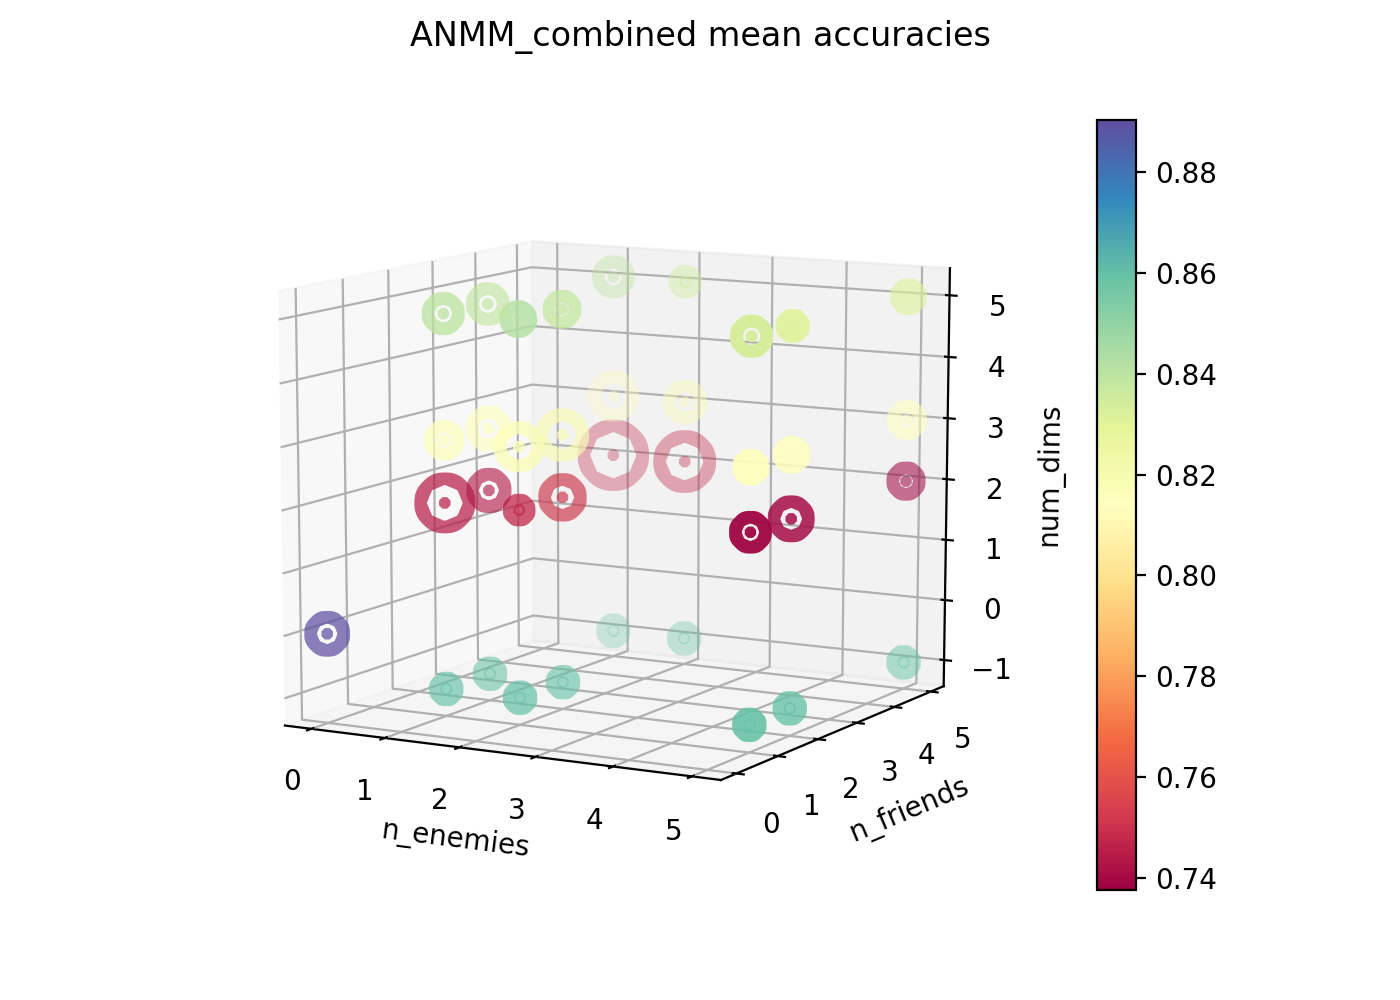

In [55]:

if z.shape[1] == 5:
    fig = plt.figure(figsize=(7, 5))

    ax = fig.add_subplot(111, projection='3d')

    x = z[:, 0]
    y = z[:, 1]
    q = z[:, 2]
    color = z[:, 3]
    width = z[:, 4] * 1e3

    im = ax.scatter(x, y, q, c=color, cmap='Spectral', marker='8', linewidth=width)

    ax.set_xlabel(axisName[0])
    ax.set_ylabel(axisName[1])
    ax.set_zlabel(axisName[2])

    fig.colorbar(im, ax=ax)


    plt.suptitle(f"{alg} mean accuracies")
    plt.show()
    
else:
    
    fig = plt.figure(figsize=(7, 5))

    ax = fig.add_subplot(111)

    x = z[:, 0]
    y = z[:, 1]
    color = z[:, -2]
    width = z[:, -1] * 1e3

    im = ax.scatter(x, y, c=color, cmap='Spectral', marker='8', linewidth=width)

    ax.set_xlabel(axisName[0])
    ax.set_ylabel(axisName[1])

    fig.colorbar(im, ax=ax)


    plt.suptitle(f"{alg} mean accuracies")
    plt.show()

----  

This work has investigate the application of metric learning algorithms onto the Perovskite SD2E dataset. 

It was shown in a recent paper that one of the better classification algorithms for determining if a perovskite crystal would form for a given reaction parameter set could be determined by using a k-nearest-neighbor algorithm where the value of k was equal to 1. In fact that classifier had a roughly 90% accuracy rate when controlling for imbalanced sample sizes of different amines. Given infinite data however, a 1-NN classifier is effectively a memorization of the training data. 

However, distance based methods such as kNN are often reliant on good underlying structure inherent in the data. This structure can be provided by reality often times as reality follows certain phyical rules, and can be exploited if the right data is captured. However, there is no reason to believe that the defaul distance metric used in distance based classifiers is appropriate for most problems. 

Given the sheer size of the perovskite data, an interesting question is `can a distance metric be learned from the data itself instead of being imposed by assumptions the scientist makes`? Furthermore, can a the kNN classifier be improved if a learned distance metric is used. 

This work investigated this hypothesis. 

In addition to invesigating the application of distance-learning algorithms, I uncovered and fixed bugs in an open-source python distance-metric-learning package: https://github.com/jlsuarezdiaz/pyDML. The squashed bugs include fixing numerical precision errors on several algorithms thereby aiding convergence of these algorithms, and updating code to use up-to-date effecient data packages. 

tl;dr -- it turns out that learning a distance function doesn't make a huge difference over the default euclidean distance, and while there are cases where classifiers can be improved, the standard euclidean distance is competitive with well-performing learned distance metrics. 


In [40]:
df

,best_hyperparam,best_mean,best_std
Average Neighborhood Margin Maximization,"{'num_dims': None, 'n_friends': 1, 'n_enemies'...",0.891184,0.007785
Distance Metric Learning through the Maximization of the Jeffrey divergence,"{'num_dims': None, 'n_neighbors': 5}",0.901316,0.003675
Neighbourhood Component Analysis,"{'num_dims': None, 'eta0': 0.01}",0.887763,0.009041
Nearest Class with Multiple Centroids,"{'num_dims': None, 'centroids_num': 1, 'initia...",0.883684,0.015482
Nearest Class Mean Metric Learning,"{'num_dims': None, 'initial_transform': 'scale'}",0.903026,0.010609
k-Nearest-Neighbors,{'n_neighbors': 5},0.890316,0.012328


In [233]:
df = pd.DataFrame(z[:-1])

In [234]:
df.rename(columns={0:axisName[0], 
                   1:axisName[1], 
                   2:axisName[2],
                   3:'mean',
                   4:'std'}, 
         inplace=True)

In [235]:
df

,n_enemies,n_friends,num_dims,mean,std
0,1.0,1.0,2.0,0.744474,0.017769
1,2.0,1.0,2.0,0.748289,0.007560
2,5.0,1.0,2.0,0.738816,0.011215
3,1.0,2.0,2.0,0.743553,0.012095
4,2.0,2.0,2.0,0.751316,0.013276
5,5.0,2.0,2.0,0.739474,0.012730
6,1.0,5.0,2.0,0.747500,0.021536
7,2.0,5.0,2.0,0.748158,0.018442
8,5.0,5.0,2.0,0.737632,0.009937
9,1.0,1.0,3.0,0.816184,0.010445


In [236]:
df.to_csv(f"{alg}_results.csv", index=False)